##Imports & Data Prep


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [07:55<00:00, 22.3MB/s]
100% 9.51G/9.51G [07:55<00:00, 21.5MB/s]


In [ ]:
import zipfile
import io

# Replace 'your_file_name.zip' with the actual name of your uploaded ZIP file
zip_file_path = '/content/aptos2019-blindness-detection.zip'

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into a folder named 'extracted_files'
    zip_ref.extractall('/content/extracted')

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from PIL import Image

In [ ]:
import os
import pandas as pd

def create_dataframe(folder_path):
    # Get the paths for train_set and test_set subfolders
    train_set_path = os.path.join(folder_path, '/content/extracted/train_images')
    test_set_path = os.path.join(folder_path, '/content/extracted/test_images')

    # Read the CSV file
    csv_file_path = os.path.join(folder_path, '/content/extracted/train.csv')
    df_labels = pd.read_csv(csv_file_path)

    # Create a list to store image paths and labels
    image_paths = []
    labels = []

    # Iterate over the files in train_set folder
    for filename in os.listdir(train_set_path):
        # Check if the file is a regular file
        if os.path.isfile(os.path.join(train_set_path, filename)):
            # Add the image path to the list
            image_paths.append(os.path.join(train_set_path, filename))
            # Get the label corresponding to the filename from the CSV file
            id_code = filename.split('.')[0]  # Remove the file extension
            label = df_labels[df_labels['id_code'] == id_code]['diagnosis'].values[0]
            labels.append(label)

    # Create a DataFrame using pandas
    df = pd.DataFrame({'image_path': image_paths, 'label': labels})

    return df

# Example usage
folder_path = '/content/extracted'
split_df = create_dataframe(folder_path)

In [ ]:
split_df

,image_path,label
0,/content/extracted/train_images/382752f6694a.png,1
1,/content/extracted/train_images/8421107255ae.png,2
2,/content/extracted/train_images/fe06dad6851c.png,0
3,/content/extracted/train_images/a14bbd9a583e.png,3
4,/content/extracted/train_images/542964865b1e.png,0
...,...,...
3657,/content/extracted/train_images/a76132e79688.png,0
3658,/content/extracted/train_images/12e6e66c80a7.png,2
3659,/content/extracted/train_images/1ca35d483772.png,0
3660,/content/extracted/train_images/1b495ac025b7.png,3


In [ ]:
import os
import pandas as pd

tst_df_path = "/content/extracted/test_images"
labels = []
filepaths = []

# Iterate over files directly within tst_df_path
for file in os.listdir(tst_df_path):
    filepath = os.path.join(tst_df_path, file)

    # Extract label from file name or path, if applicable
    label = ...  # You may need to implement this based on your file naming convention
    labels.append(label)
    filepaths.append(filepath)

# Create pandas Series for labels and file paths
l = pd.Series(labels, name="label")
f = pd.Series(filepaths, name="image_path")

# Concatenate Series to form DataFrame
test_df = pd.concat([f, l], axis=1)

In [ ]:
test_df

,image_path,label
0,/content/extracted/test_images/76c854fde95e.png,Ellipsis
1,/content/extracted/test_images/3c6bee77688a.png,Ellipsis
2,/content/extracted/test_images/0952ca2ece1c.png,Ellipsis
3,/content/extracted/test_images/3fa9277a3780.png,Ellipsis
4,/content/extracted/test_images/1a495e43fc7d.png,Ellipsis
...,...,...
1923,/content/extracted/test_images/d25c41b91aa6.png,Ellipsis
1924,/content/extracted/test_images/d6320a089dcf.png,Ellipsis
1925,/content/extracted/test_images/a00e9f3e46b3.png,Ellipsis
1926,/content/extracted/test_images/ec248c3ecd10.png,Ellipsis


In [ ]:
# Splitting test dataset into TEST and VAL datasets
train_df, val_df = train_test_split(split_df, test_size=0.2, random_state=50, stratify=None)

# Display the shapes of the resulting datasets
print("train shape:", train_df.shape)
print("VAL shape:", val_df.shape)

train shape: (2929, 2)
VAL shape: (733, 2)


##Pre-Process

In [ ]:
img_size = (224, 224)

tr = ImageDataGenerator()
ts = ImageDataGenerator()

# Convert integer labels to strings
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

train_gen = tr.flow_from_dataframe(train_df, x_col="image_path", y_col="label",
                                    target_size=img_size,
                                    batch_size=32, shuffle=True,
                                    class_mode='categorical', color_mode="rgb")

valid_gen = ts.flow_from_dataframe(val_df, x_col='image_path', y_col='label',
                                   target_size=img_size,
                                   class_mode='categorical', color_mode="rgb",
                                   shuffle=True, batch_size=16)

test_gen = ts.flow_from_dataframe(test_df, x_col='image_path', y_col='label',
                                  target_size=img_size,
                                  batch_size=32, shuffle=False,
                                  color_mode="rgb", class_mode='categorical')


Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames belonging to 1 classes.


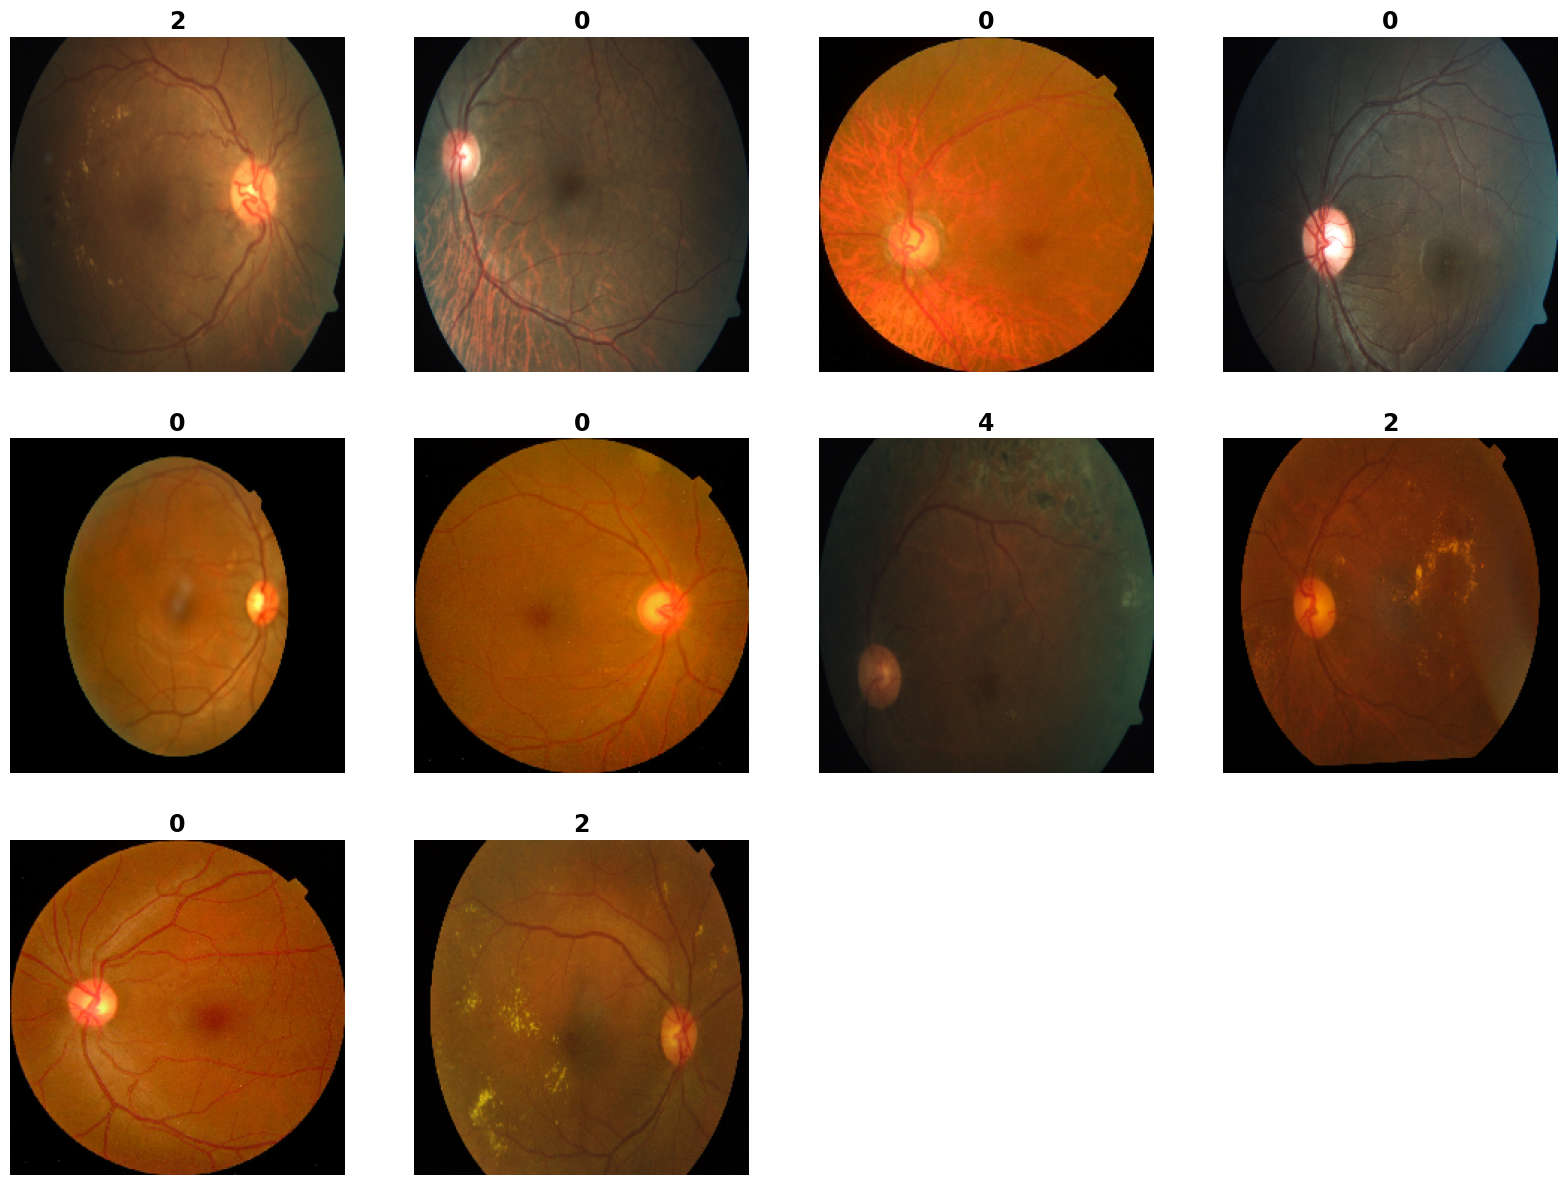

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range():
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 17,weight="bold")
    plt.axis('off')
plt.show()

##Model Building

In [ ]:
print('Train Shape: ',train_df.shape)
print('Valid Shape: ',val_df.shape)

Train Shape:  (2929, 2)
Valid Shape:  (733, 2)


In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# # Define your model
# model = Sequential([

#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),

#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(5, activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2


#Different model arch

INIT_LR=0.0001
EPOCHS=6
DECAY = 1e-6

model2 = Sequential([

    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

opt = Adam(learning_rate=INIT_LR, decay=DECAY)

# Compile the model
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_9 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_67 (Conv2D)          (None, 222, 222, 32)      9248      
                                                                 
 batch_normalization_10 (Ba  (None, 222, 222, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                     

##Training

In [ ]:
# # Train the model
# history = model.fit(
#     train_gen,
#     steps_per_epoch=len(train_gen),
#     epochs=EPOCHS,
#     validation_data=valid_gen,
#     validation_steps=len(valid_gen)
# )

In [ ]:
# Train the model
history = model2.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS,
    validation_data=valid_gen,
    validation_steps=len(valid_gen)
)

Epoch 1/6
66/92 [====================>.........] - ETA: 1:27 - loss: 11.0346 - accuracy: 0.6285

##Evaluation

In [ ]:
plt.figure(figsize=(20, 8))
tr_loss=history.history["loss"]
val_loss=history.history["val_loss"]
index_loss=np.argmin(val_loss)
loss_lowest=val_loss[index_loss]
l_label=f"best epoch {index_loss+1}"

tr_accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
index_acc=np.argmax(val_accuracy)
acc_highest=tr_accuracy[index_acc]
c_label=f"best epoch {index_acc+1}"

epochs=[i+1 for i in range (len(tr_accuracy))]


plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs,tr_loss,"r",label="train loss")
plt.plot(epochs,val_loss,"g",label="valid loss")
plt.scatter(index_loss+1,loss_lowest,c="b",s=150,label=l_label)
plt.title('Training and Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs,tr_accuracy,"r",label="train accuracy")
plt.plot(epochs,val_accuracy,"g",label="valid accuracy")
plt.scatter(index_acc+1,acc_highest,c="b",s=150,label=c_label)
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()


plt.suptitle('Model Training Metrics Over Epochs', fontsize=20);

In [ ]:
train_score=model2.evaluate(train_gen)
valid_score=model2.evaluate(valid_gen)
test_score=model2.evaluate(test_gen)

print(f"Train Loss : {train_score[0]:.3f}")
print(f"Train Accuracy : {train_score[1]*100:.2f}%")
print("-"*20)
print(f"Validation Loss : {valid_score[0]:.3f}")
print(f"Validation Accuracy : {valid_score[1]*100:.2f}%")
print("-"*20)
print(f"Test Loss: {test_score[0]:.3f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

In [ ]:
preds=model2.predict(test_gen)
y_pred=np.argmax(preds,axis=1)